# CE ARR

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

## Data Pre-processing

In [477]:
df_train = pd.read_csv('../train_data.nosync/train_data.csv', header=None)
df_val = pd.read_csv('./val_data.csv', header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,-0.265,-0.265,-0.290,-0.310,-0.325,-0.315,-0.295,-0.280,-0.285,-0.280,...,-0.170,-0.145,-0.155,-0.170,-0.180,-0.185,-0.190,-0.19,-0.200,0.0
1,-0.110,-0.110,-0.105,-0.095,-0.080,-0.050,-0.050,-0.050,-0.050,-0.040,...,-0.315,-0.285,-0.275,-0.265,-0.260,-0.275,-0.290,-0.28,-0.275,12.0
2,-0.380,-0.380,-0.400,-0.415,-0.395,-0.380,-0.380,-0.395,-0.390,-0.415,...,-0.390,-0.410,-0.445,-0.435,-0.420,-0.415,-0.400,-0.41,-0.425,0.0
3,-0.955,-0.945,-0.960,-0.960,-0.970,-0.970,-0.955,-0.935,-0.940,-0.920,...,-0.995,-1.000,-1.010,-1.040,-1.040,-1.025,-1.020,-1.00,-0.990,0.0
4,0.030,0.030,0.055,0.060,0.040,0.030,0.035,0.040,0.060,0.050,...,-0.010,0.000,-0.005,-0.025,-0.015,-0.020,-0.015,0.01,0.005,0.0


In [478]:
df_train.shape

(65670, 251)

In [479]:
# Split the training data into feature and target
X_train = df_train.iloc[:,:-1].values
y_train = df_train.iloc[:,-1:].values.ravel()
X_val = df_val.iloc[:,:-1].values
y_val = df_val.iloc[:,-1:].values.ravel()

## Fourier Attempt

In [480]:
time = np.arange(0, 250)
fx_train = df_train.iloc[:,:-1].values
fy_train = df_train.iloc[:,-1:].values.ravel()
fx_val = df_val.iloc[:,:-1].values
fy_val = df_val.iloc[:,-1:].values.ravel()

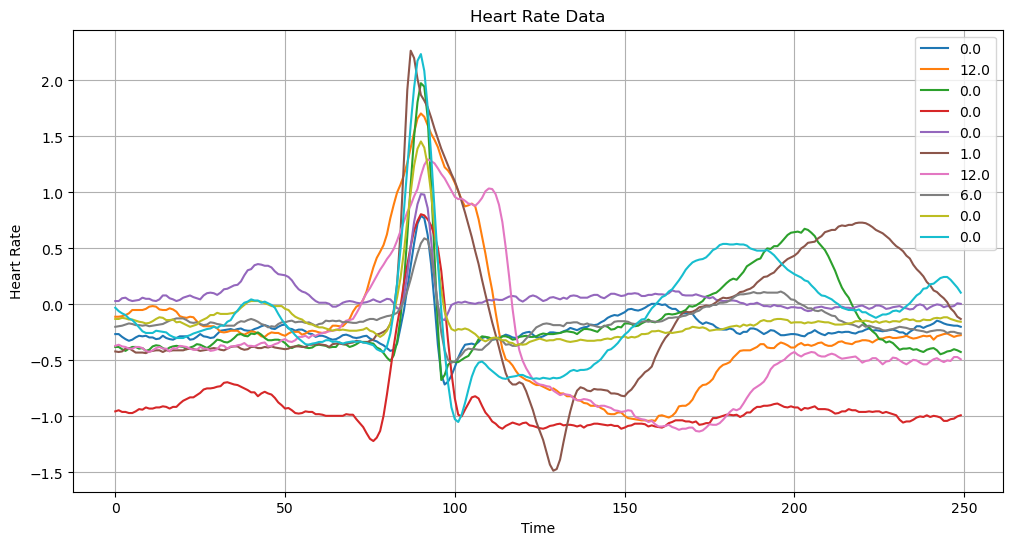

In [481]:
plt.figure(figsize=(12, 6))

cnt = 10
for beat in fx_train[:cnt]:
    plt.plot(beat)

plt.legend(y_train[:cnt])
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.title('Heart Rate Data')
plt.grid()
plt.show()

In [482]:
# Parameter to determine frequency breadth of the FFT data as percentage of spectrum
total_breadth = len(fx_train[0])
perc = 0.5

breadth = (perc*total_breadth)
breadth = int(breadth)
breadth

125

In [483]:
# Calculate FFT's for the Train Set
# Number (count) of beats to apply transform too and arrays for data
cnt = len(fx_train)
fx_train_mags = []
fx_train_magsdb = []
fx_train_freqs = []


for beat in fx_train[:cnt]:
    # Calculate the FFT
    fft_result = np.fft.fft(beat)

    # Calculate freq values corresponding with the FFT result
    freq = np.fft.fftfreq(len(time))

    # Eliminate negative frequencies
    pos_freqs = freq > 0
    fft_result = fft_result[pos_freqs]
    freq = freq[pos_freqs]

    # Calculate magnitude of the FFT result
    mag = np.abs(fft_result)
    mag_db = 20 * np.log10(mag)

    fx_train_mags.append(mag[0:breadth])
    fx_train_magsdb.append(mag_db[0:breadth])
    fx_train_freqs.append(freq[0:breadth])

In [484]:
# Calculate FFT's for the Validation Set
cnt = len(fx_val)
fx_val_mags = []
fx_val_magsdb = []
fx_val_freqs = []

for beat in fx_val[:cnt]:
    # Calculate the FFT
    fft_result = np.fft.fft(beat)

    # Calculate freq values corresponding with the FFT result
    freq = np.fft.fftfreq(len(time))

    # Eliminate negative frequencies
    pos_freqs = freq > 0
    fft_result = fft_result[pos_freqs]
    freq = freq[pos_freqs]

    # Calculate magnitude of the FFT result
    mag = np.abs(fft_result)
    mag_db = 20 * np.log10(mag)

    fx_val_mags.append(mag[0:breadth])
    fx_val_magsdb.append(mag_db[0:breadth])
    fx_val_freqs.append(freq[0:breadth])

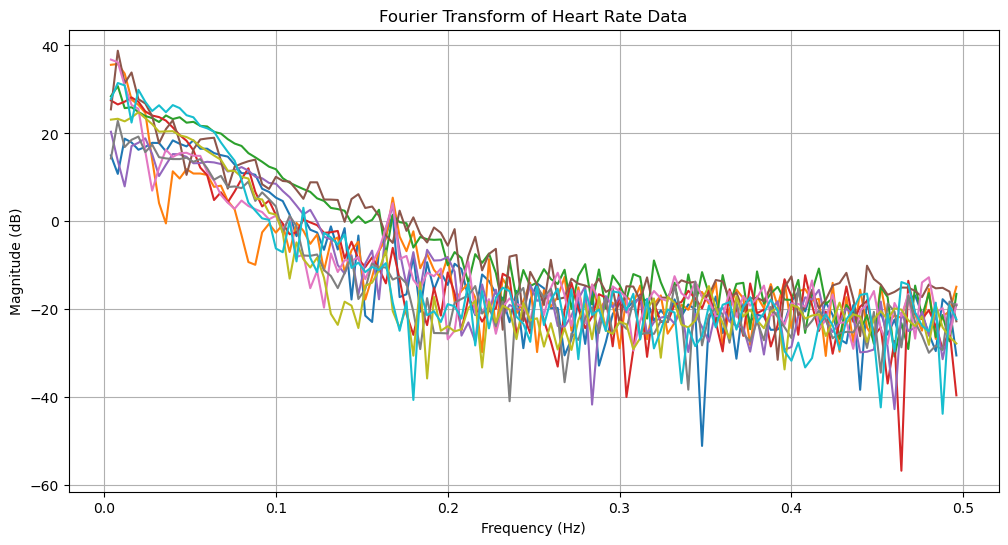

In [485]:
# Determine amount and plot some FFT training data samples
plt_cnt = 10
plt.figure(figsize=(12, 6))

for beat in fx_train_magsdb[:plt_cnt]:
    plt.plot(fx_train_freqs[0], beat)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Fourier Transform of Heart Rate Data')
plt.grid()
plt.show()

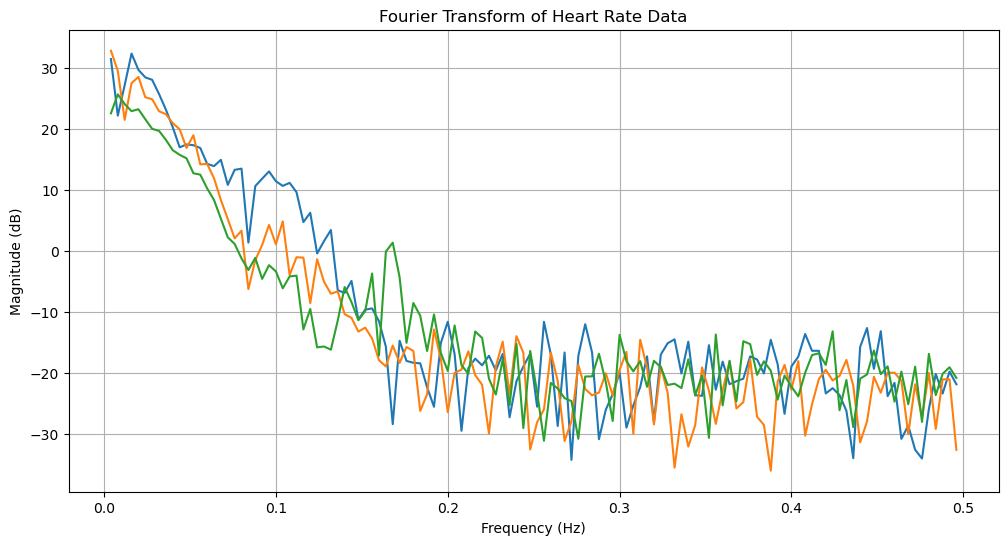

In [486]:
# Determine amount and plot some FFT validation data samples
plt_cnt = 3
plt.figure(figsize=(12, 6))

for beat in fx_val_magsdb[:plt_cnt]:
    plt.plot(fx_val_freqs[0], beat)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Fourier Transform of Heart Rate Data')
plt.grid()
plt.show()

[0.33663034 0.43899419 0.50291605 0.52943996 0.54808254 0.55992822
 0.56910119 0.57637818 0.58265251 0.58888568 0.59486518 0.60065225
 0.60610397 0.61142393 0.61665097 0.62178205 0.62682284 0.63179041
 0.63669549 0.6415642 ]


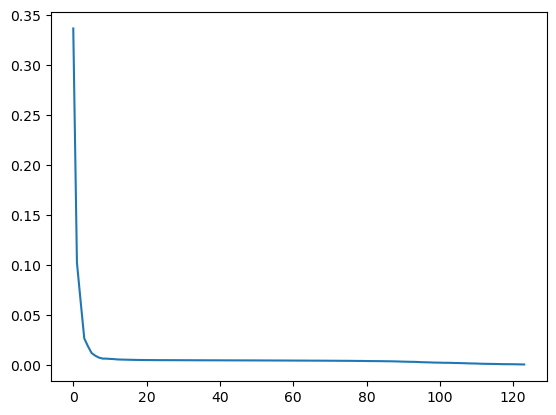

In [487]:
# apply PCA to the Fourier Data in dB
pca = PCA()
pca.fit(fx_train_magsdb)
X_train_pca = pca.transform(fx_train_magsdb)
X_val_pca = pca.transform(fx_val_magsdb)
print(np.cumsum(pca.explained_variance_ratio_[0:20]))
plt.plot(pca.explained_variance_ratio_)
plt.show()

[0.65326157 0.80315087 0.87554787 0.91503343 0.94659759 0.96439574
 0.97434987 0.98039935 0.98428026 0.9877266  0.98983553 0.99141706
 0.99271531 0.99361515 0.99450394 0.99512124 0.99567323 0.99616643
 0.99656239 0.99693287]


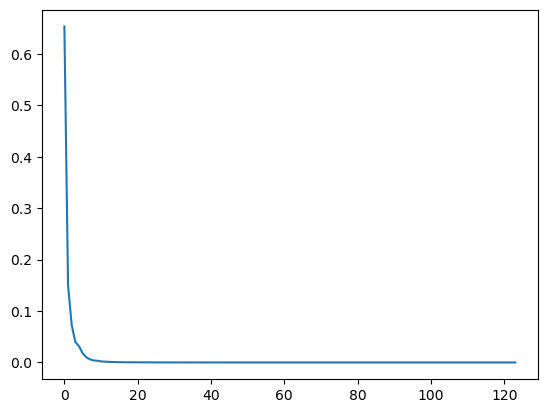

In [488]:
# apply PCA to the Fourier Data (non dB)
pca = PCA()
pca.fit(fx_train_mags)
X_train_pca = pca.transform(fx_train_mags)
X_val_pca = pca.transform(fx_val_mags)
print(np.cumsum(pca.explained_variance_ratio_[0:20]))
plt.plot(pca.explained_variance_ratio_)
plt.show()

[0.65326157 0.80315087 0.87554787 0.91503343 0.94659759 0.96439574
 0.97434987 0.98039935 0.98428026 0.9877266  0.98983553 0.99141706
 0.99271531 0.99361515 0.99450394 0.99512124 0.99567323 0.99616643
 0.99656239 0.99693287]


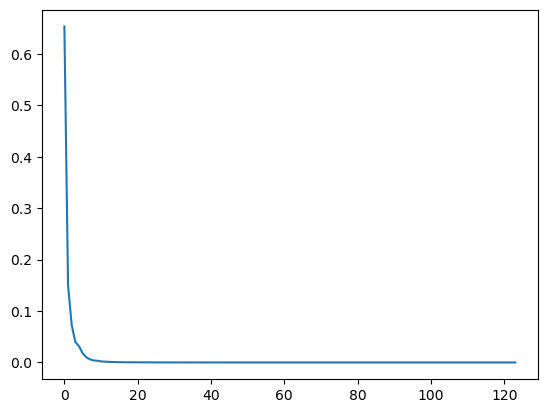

In [489]:
# apply PCA to the Fourier Data (non dB)
pca = PCA()
pca.fit(fx_train_mags)
X_train_pca = pca.transform(fx_train_mags)
X_val_pca = pca.transform(fx_val_mags)
print(np.cumsum(pca.explained_variance_ratio_[0:20]))
plt.plot(pca.explained_variance_ratio_)
plt.show()

## Pure Arrythmia Split

In [490]:
xa_train = np.copy(fx_train_mags)
ya_train = np.copy(y_train)
xa_val = np.copy(fx_val_mags)
ya_val = np.copy(y_val)

In [491]:
# Find the indices of non-zero elements in the train and validate arrays
non_zero_indices_train = np.where(ya_train != 0)[0]
print(non_zero_indices_train)
non_zero_indices_val = np.where(ya_val != 0)[0]
print(non_zero_indices_val)

[    1     5     6 ... 65665 65666 65668]
[    0     3     4 ... 21885 21887 21890]


In [492]:
# Mask all arrays to only contain arrythmia data
xap_train = xa_train[non_zero_indices_train]
yap_train = ya_train[non_zero_indices_train]

xap_val = xa_val[non_zero_indices_val]
yap_val = ya_val[non_zero_indices_val]

# print(xap_train)
# print(yap_train)
# print(xap_val)
# print(yap_val)

In [494]:
clf_kn = KNeighborsClassifier(1)
clf_kn.fit(xap_train, yap_train)
y_prediction_kn = clf_kn.predict(xap_val)
print("K Neighbours Classifier")
print("Accuracy: " + str(accuracy_score(yap_val, y_prediction_kn)))
print("F1 score: " + str(f1_score(yap_val, y_prediction_kn, average='macro')))
print("Recall score: " + str(recall_score(yap_val, y_prediction_kn, average='macro')))
print("Precision score: " + str(precision_score(yap_val, y_prediction_kn, average='macro')))

K Neighbours Classifier
Accuracy: 0.9684867847807145
F1 score: 0.8328332225824239
Recall score: 0.8276407124359093
Precision score: 0.8423886886154228


/Users/zacho/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


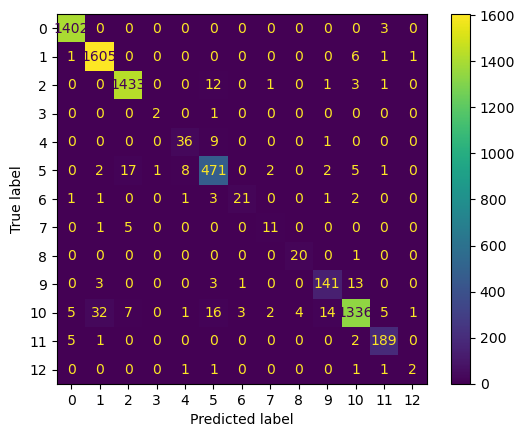

In [495]:
#Confusion matrix
c_matrix = confusion_matrix(yap_val, y_prediction_kn)
ConfusionMatrixDisplay(c_matrix).plot()

In [501]:
clf_kn = KNeighborsClassifier(3)
clf_kn.fit(xap_train, yap_train)
y_prediction_kn = clf_kn.predict(xap_val)
print("K Neighbours Classifier")
print("Accuracy: " + str(accuracy_score(yap_val, y_prediction_kn)))
print("F1 score: " + str(f1_score(yap_val, y_prediction_kn, average='macro')))
print("Recall score: " + str(recall_score(yap_val, y_prediction_kn, average='macro')))
print("Precision score: " + str(precision_score(yap_val, y_prediction_kn, average='macro')))

/Users/zacho/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


K Neighbours Classifier
Accuracy: 0.9661632297415045
F1 score: 0.794775852117801
Recall score: 0.7698738284910186
Precision score: 0.8547811625162276


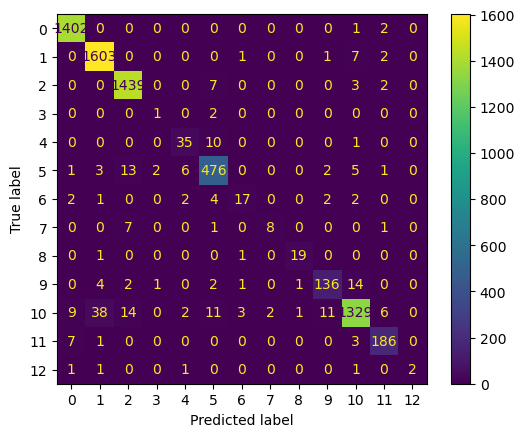

In [502]:
#Confusion matrix
c_matrix = confusion_matrix(yap_val, y_prediction_kn)
ConfusionMatrixDisplay(c_matrix).plot()

In [507]:
clf_mlp_100 = MLPClassifier(hidden_layer_sizes=(500))
clf_mlp_100.fit(xap_train, yap_train)
y_prediction_mlp_100 = clf_mlp_100.predict(xap_val)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(yap_val, y_prediction_mlp_100)))
print("F1 score: " + str(f1_score(yap_val, y_prediction_mlp_100, average='macro')))
print("Recall score: " + str(recall_score(yap_val, y_prediction_mlp_100, average='macro')))
print("Precision score: " + str(precision_score(yap_val, y_prediction_mlp_100, average='macro')))

MLP Classifier
Accuracy: 0.9681963404008133
F1 score: 0.7792006096390425
Recall score: 0.7423091035490982
Precision score: 0.8713371749997249


/Users/zacho/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


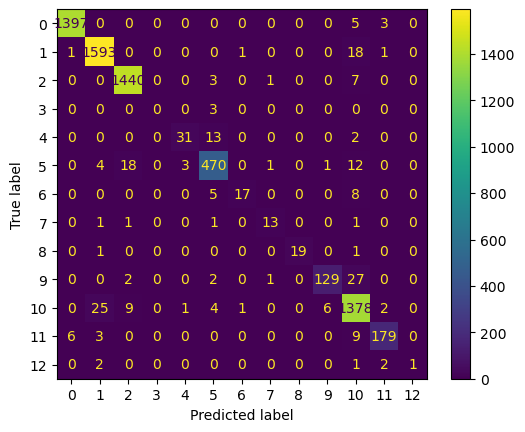

In [508]:
#Confusion matrix
c_matrix = confusion_matrix(yap_val, y_prediction_mlp_100)
ConfusionMatrixDisplay(c_matrix).plot()

## Model Refinement (FFT)

In [367]:
len(fx_train_mags)

[3. 0. 0. ... 0. 0. 2.]


In [379]:
clf_kn = KNeighborsClassifier(1)
clf_kn.fit(fx_train_mags, fy_train)
y_prediction_kn = clf_kn.predict(fx_val_mags)
print("K Neighbours Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_kn)))
print("F1 score: " + str(f1_score(y_val, y_prediction_kn, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_kn, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_kn, average='macro')))

/Users/zacho/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


K Neighbours Classifier
Accuracy: 0.9756977753414645
F1 score: 0.7899845197433623
Recall score: 0.7654099773841833
Precision score: 0.847653798102672


[3. 0. 0. ... 0. 0. 2.]


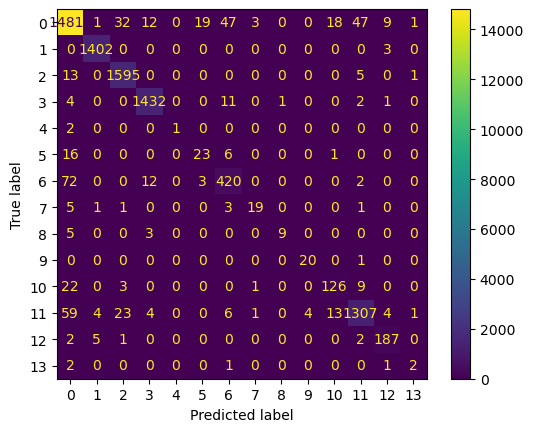

In [380]:
#Confusion matrix
c_matrix = confusion_matrix(fy_val, y_prediction_kn)
ConfusionMatrixDisplay(c_matrix).plot()

In [112]:
clf_mlp_100 = MLPClassifier(hidden_layer_sizes=(100))
clf_mlp_100.fit(fx_train_mags, fy_train)
y_prediction_mlp_100 = clf_mlp_100.predict(fx_val_mags)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_100)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_100, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_100, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_100, average='macro')))

MLP Classifier
Accuracy: 0.9713124114933077
F1 score: 0.7709732936027596
Recall score: 0.7339889700800909
Precision score: 0.8417713697307374


/Users/zacho/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


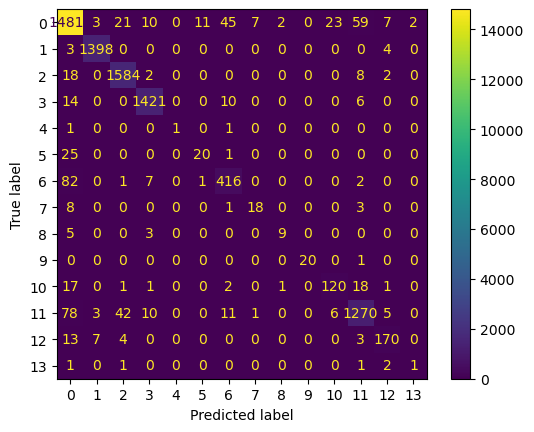

In [113]:
#Confusion matrix
c_matrix = confusion_matrix(fy_val, y_prediction_mlp_100)
ConfusionMatrixDisplay(c_matrix).plot()

## Attempting to do arrythmia and non-arrythmia

In [423]:
# Turn all non-0 class tags to be 1 in testing and training sets
print(fy_train)
y_twoclass_train = np.copy(fy_train)
y_twoclass_train[y_twoclass_train != 0] = 1
print(y_twoclass_train)

print(fy_val)
y_twoclass_val = np.copy(fy_val)
y_twoclass_val[y_twoclass_val != 0] = 1
print(y_twoclass_val)

[ 0. 12.  0. ...  0.  3.  0.]
[0. 1. 0. ... 0. 1. 0.]
[3. 0. 0. ... 0. 0. 2.]
[1. 0. 0. ... 0. 0. 1.]


# error here, it sets fy_val to 1/0

In [424]:
clf_kn = KNeighborsClassifier(1)
clf_kn.fit(fx_train_mags, y_twoclass_train)
y_2_prediction_kn = clf_kn.predict(fx_val_mags)
y_2_prob = y_2_prediction_kn

print("K Neighbours Classifier")
print("Accuracy: " + str(accuracy_score(y_twoclass_val, y_2_prediction_kn)))
print("F1 score: " + str(f1_score(y_twoclass_val, y_2_prediction_kn, average='macro')))
print("Recall score: " + str(recall_score(y_twoclass_val, y_2_prediction_kn, average='macro')))
print("Precision score: " + str(precision_score(y_twoclass_val, y_2_prediction_kn, average='macro')))


/Users/zacho/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


K Neighbours Classifier
Accuracy: 0.9821387784934448
F1 score: 0.9792794441576187
Recall score: 0.9790346581152202
Precision score: 0.9795252825955572


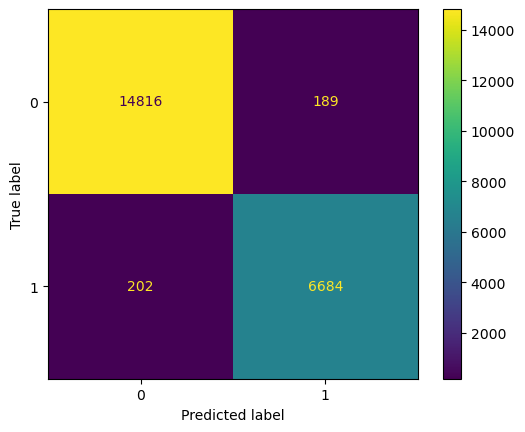

In [425]:
#Confusion matrix
c_matrix = confusion_matrix(y_twoclass_val, y_2_prediction_kn)
ConfusionMatrixDisplay(c_matrix).plot()

In [125]:
clf_kn = KNeighborsClassifier(4)
clf_kn.fit(fx_train_mags, y_twoclass_train)
y_2_4_prediction_kn = clf_kn.predict(fx_val_mags)

print("K Neighbours Classifier")
print("Accuracy: " + str(accuracy_score(y_twoclass_val, y_2_4_prediction_kn)))
print("F1 score: " + str(f1_score(y_twoclass_val, y_2_4_prediction_kn, average='macro')))
print("Recall score: " + str(recall_score(y_twoclass_val, y_2_4_prediction_kn, average='macro')))
print("Precision score: " + str(precision_score(y_twoclass_val, y_2_4_prediction_kn, average='macro')))


/Users/zacho/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


K Neighbours Classifier
Accuracy: 0.9814992462655886
F1 score: 0.9783808822912086
Recall score: 0.9747178377853136
Precision score: 0.9822852181642269


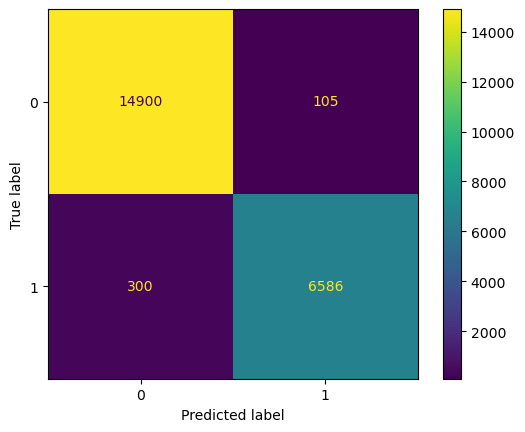

In [120]:
#Confusion matrix
c_matrix = confusion_matrix(y_twoclass_val, y_2_prediction_kn)
ConfusionMatrixDisplay(c_matrix).plot()

In [312]:
clf_mlp_50 = MLPClassifier(hidden_layer_sizes=(50))
clf_mlp_50.fit(fx_train_mags, y_twoclass_train)
y_prediction_mlp_50 = clf_mlp_50.predict(fx_val_mags)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_twoclass_val, y_prediction_mlp_50)))
print("F1 score: " + str(f1_score(y_twoclass_val, y_prediction_mlp_50, average='macro')))
print("Recall score: " + str(recall_score(y_twoclass_val, y_prediction_mlp_50, average='macro')))
print("Precision score: " + str(precision_score(y_twoclass_val, y_prediction_mlp_50, average='macro')))

MLP Classifier
Accuracy: 0.9703074322781051
F1 score: 0.965173445524843
Recall score: 0.9599533624332599
Precision score: 0.970909001730073


/Users/zacho/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


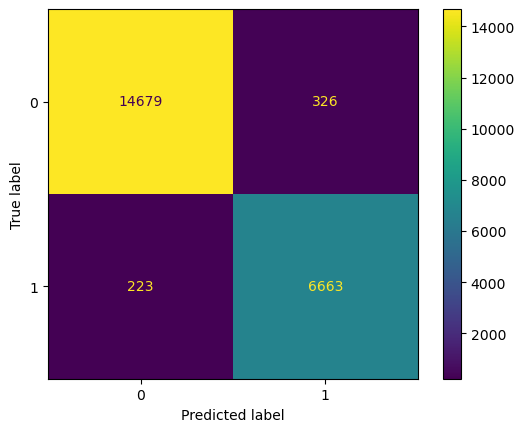

In [49]:
#Confusion matrix
c_matrix = confusion_matrix(y_twoclass_val, y_prediction_mlp_50)
ConfusionMatrixDisplay(c_matrix).plot()

In [46]:
clf_mlp_100 = MLPClassifier(hidden_layer_sizes=(100))
clf_mlp_100.fit(fx_train_mags, y_twoclass_train)
y_prediction_mlp_100 = clf_mlp_100.predict(fx_val_mags)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_twoclass_val, y_prediction_mlp_100)))
print("F1 score: " + str(f1_score(y_twoclass_val, y_prediction_mlp_100, average='macro')))
print("Recall score: " + str(recall_score(y_twoclass_val, y_prediction_mlp_100, average='macro')))
print("Precision score: " + str(precision_score(y_twoclass_val, y_prediction_mlp_100, average='macro')))

MLP Classifier
Accuracy: 0.9761089032022292
F1 score: 0.972402981119108
Recall score: 0.9742039467336041
Precision score: 0.9706594210302063


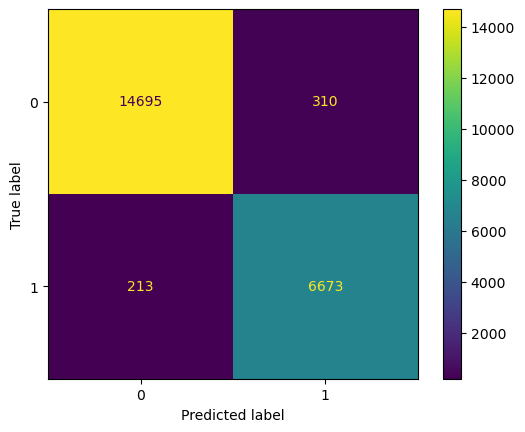

In [47]:
#Confusion matrix
c_matrix = confusion_matrix(y_twoclass_val, y_prediction_mlp_100)
ConfusionMatrixDisplay(c_matrix).plot()

In [50]:
clf_mlp_300 = MLPClassifier(hidden_layer_sizes=(300))
clf_mlp_300.fit(fx_train_mags, y_twoclass_train)
y_prediction_mlp_300 = clf_mlp_300.predict(fx_val_mags)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_twoclass_val, y_prediction_mlp_300)))
print("F1 score: " + str(f1_score(y_twoclass_val, y_prediction_mlp_300, average='macro')))
print("Recall score: " + str(recall_score(y_twoclass_val, y_prediction_mlp_300, average='macro')))
print("Precision score: " + str(precision_score(y_twoclass_val, y_prediction_mlp_300, average='macro')))

MLP Classifier
Accuracy: 0.9785299894933991
F1 score: 0.9751639999575155
Recall score: 0.9762843356600177
Precision score: 0.9740657918654994


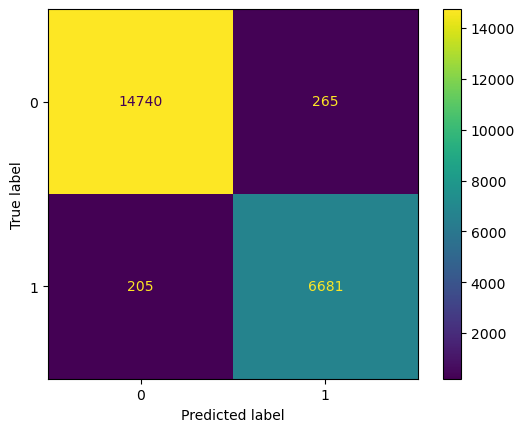

In [51]:
#Confusion matrix
c_matrix = confusion_matrix(y_twoclass_val, y_prediction_mlp_300)
ConfusionMatrixDisplay(c_matrix).plot()

In [52]:
clf_mlp_1000 = MLPClassifier(hidden_layer_sizes=(1000))
clf_mlp_1000.fit(fx_train_mags, y_twoclass_train)
y_prediction_mlp_1000 = clf_mlp_1000.predict(fx_val_mags)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_twoclass_val, y_prediction_mlp_1000)))
print("F1 score: " + str(f1_score(y_twoclass_val, y_prediction_mlp_1000, average='macro')))
print("Recall score: " + str(recall_score(y_twoclass_val, y_prediction_mlp_1000, average='macro')))
print("Precision score: " + str(precision_score(y_twoclass_val, y_prediction_mlp_1000, average='macro')))

MLP Classifier
Accuracy: 0.9820474167466082
F1 score: 0.9790922993240394
Recall score: 0.9770035702108397
Precision score: 0.9812585574387102


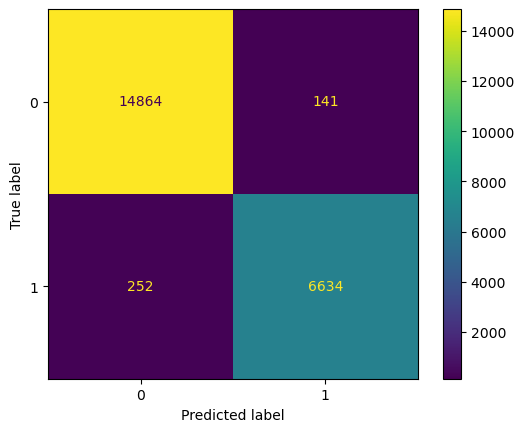

In [54]:
#Confusion matrix
c_matrix = confusion_matrix(y_twoclass_val, y_prediction_mlp_1000)
ConfusionMatrixDisplay(c_matrix).plot()

## Combine 2 and 14 class models

In [275]:
#refined_predictions = np.copy(y_prediction_kn)

# # for i in [0,1,2,3,4]:
# #     print(refined_predictions[i])
# #     print(y_2_prob[i])

# # refined_predictions[y_2_prob[:,0] == 1] = 0
# # print()

# # for i in [0,1,2,3,4]:
# #     print(refined_predictions[i])
# #     print(y_2_prob[i])

# high_confidence_indices = np.where(y_2_prob[:,0] == 1)[0]

# # Refine the predictions for these high confidence indices
# refined_predictions[high_confidence_indices] = 0 

In [382]:

my_array = [i for i in range(100)] 

for i in my_array:
    print(refined_predictions[i])

3.0
0.0
0.0
1.0
12.0
0.0
0.0
0.0
0.0
3.0
2.0
0.0
0.0
0.0
0.0
1.0
0.0
2.0
0.0
0.0
0.0
2.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
0.0
12.0
0.0
12.0
3.0
0.0
12.0
0.0
0.0
0.0
0.0
0.0
6.0
2.0
0.0
0.0
12.0
0.0
0.0
0.0
11.0
3.0
0.0
0.0
3.0
0.0
0.0
0.0
13.0
0.0
12.0
0.0
0.0
3.0
13.0
0.0
0.0
2.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
12.0
0.0
0.0
0.0
0.0
0.0


[3. 0. 0. ... 0. 0. 2.]


In [370]:
print("K Neighbours Classifier")
print("Accuracy: " + str(accuracy_score(y_val, refined_predictions)))
print("F1 score: " + str(f1_score(y_val, refined_predictions, average='macro')))
print("Recall score: " + str(recall_score(y_val, refined_predictions, average='macro')))
print("Precision score: " + str(precision_score(y_val, refined_predictions, average='macro')))

K Neighbours Classifier
Accuracy: 0.9756977753414645
F1 score: 0.7899845197433623
Recall score: 0.7654099773841833
Precision score: 0.847653798102672


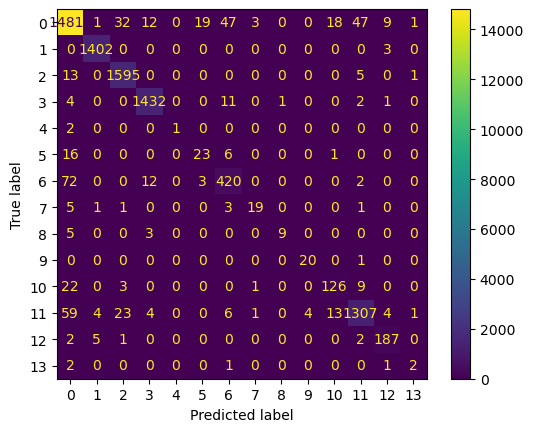

In [371]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, refined_predictions)
ConfusionMatrixDisplay(c_matrix).plot()

In [373]:
clf_kn = KNeighborsClassifier(1)
clf_kn.fit(fx_train_mags, fy_train)
y_prediction_kn = clf_kn.predict(fx_val_mags)
print("K Neighbours Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_kn)))
print("F1 score: " + str(f1_score(y_val, y_prediction_kn, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_kn, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_kn, average='macro')))

/Users/zacho/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


K Neighbours Classifier
Accuracy: 0.9756977753414645
F1 score: 0.7899845197433623
Recall score: 0.7654099773841833
Precision score: 0.847653798102672


[3. 0. 0. ... 0. 0. 2.]


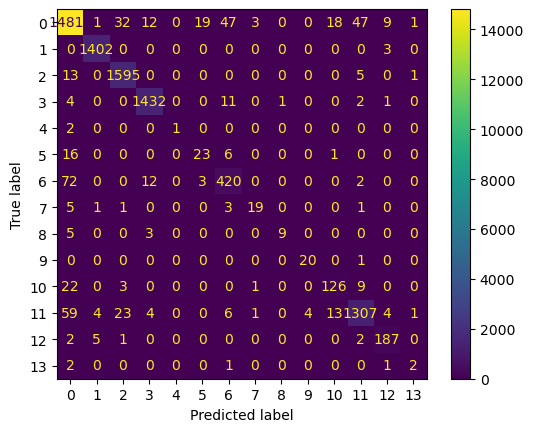

In [374]:
#Confusion matrix
c_matrix = confusion_matrix(fy_val, y_prediction_kn)
ConfusionMatrixDisplay(c_matrix).plot()

In [304]:
print(y_2_prob)
print(y_prediction_kn)

[1. 0. 0. ... 0. 0. 1.]
[3. 0. 0. ... 0. 0. 2.]


In [426]:
refined_predictions = np.copy(y_prediction_kn)

# for i in [0,1,2,3,4]:
#     print(refined_predictions[i])
#     print(y_2_prob[i])

#if refined_predictions[y_2_prob[:,0] == 1]:
    
    
for i in np.arange(refined_predictions.shape[0]):
    if (y_2_prob[i] == 1):
        refined_predictions[i] = y_prediction_kn[i]
    else:
        refined_predictions[i] = 0
    
print(refined_predictions)

# for i in [0,1,2,3,4]:
#     print(refined_predictions[i])
#     print(y_2_prob[i])

[3. 0. 0. ... 0. 0. 2.]


In [428]:
for i in np.arange(refined_predictions.shape[0]):
    if refined_predictions[i] != y_prediction_kn[i]:
        print("x")
        
# for i in np.arange(refined_predictions.shape[0]):
#     print(str(y_2_prob[i]) + " " + str(refined_predictions[i]))
    
# for i in np.arange(refined_predictions.shape[0]):
#     print( str(y_2_prob[i]) + " -- " + str(refined_predictions[i])  + " -- " + str(fy_val[i]))

In [308]:
print("K Neighbours Classifier")
print("Accuracy: " + str(accuracy_score(y_val, refined_predictions)))
print("F1 score: " + str(f1_score(y_val, refined_predictions, average='macro')))
print("Recall score: " + str(recall_score(y_val, refined_predictions, average='macro')))
print("Precision score: " + str(precision_score(y_val, refined_predictions, average='macro')))

K Neighbours Classifier
Accuracy: 0.7413092138321685
F1 score: 0.0948041866368703
Recall score: 0.08517556648648202
Precision score: 0.14184583999150469


/Users/zacho/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


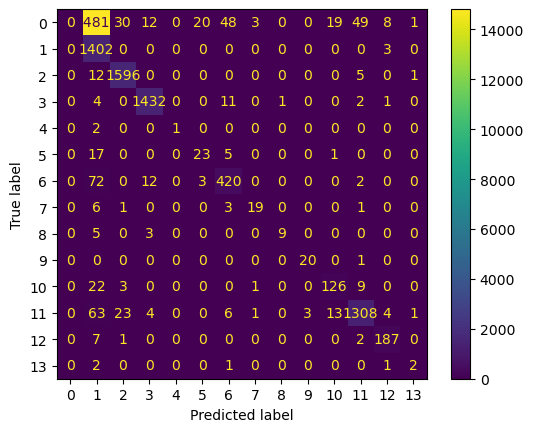

In [186]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, refined_predictions)
ConfusionMatrixDisplay(c_matrix).plot()

## Feature Design

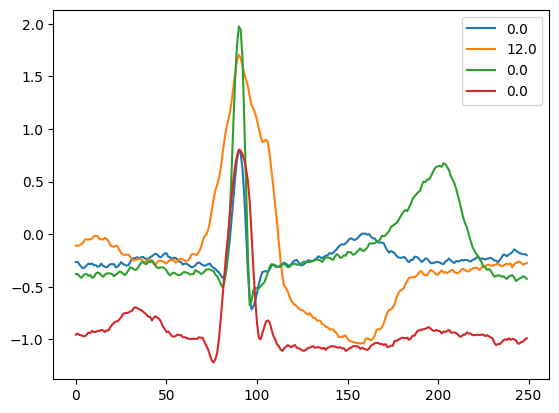

In [20]:
# plot the first few samples to visualize the data of X_train
for beat in X_train[:4]:
    plt.plot(beat)
plt.legend(y_train[:4])
plt.show()

In [21]:
def getMaxBinMean(histogram):
    (hist, edges) = histogram
    maxBin = np.argmax(hist)
    return np.mean(edges[maxBin:maxBin+2])

In [22]:
mids_train = np.array([getMaxBinMean(np.histogram(dat)) for dat in X_train])
X_train_Shifted = (X_train.transpose()-mids_train.transpose()).transpose()
mids_val = np.array([getMaxBinMean(np.histogram(dat)) for dat in X_val])
X_val_Shifted = (X_val.transpose()-mids_val.transpose()).transpose()

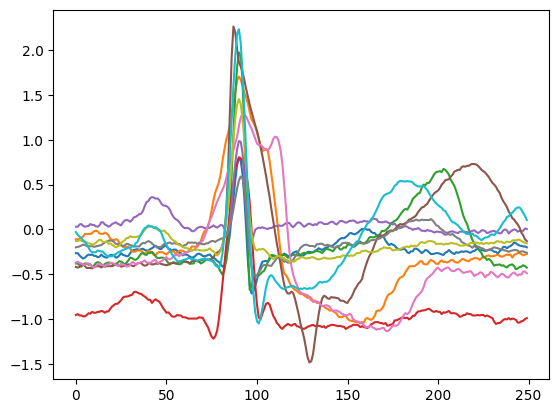

In [23]:
for beat in X_train[:10]:
    plt.plot(beat)

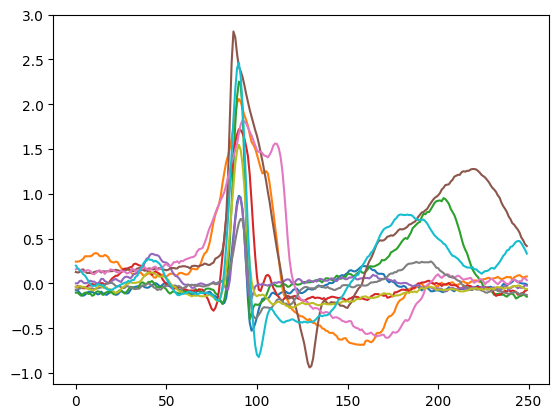

In [24]:
for beat in X_train_Shifted[:10]:
    plt.plot(beat)

In [25]:
#create a new feature that includes the derivatives in indices 250 to 498
X_train_with_der = np.concatenate((X_train, np.diff(X_train)),axis=1)
X_val_with_der = np.concatenate((X_val, np.diff(X_val)),axis=1)

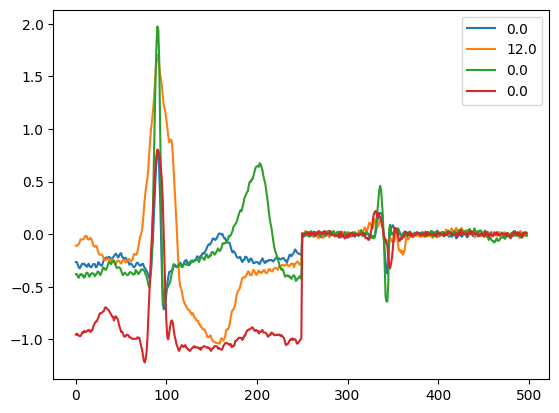

In [26]:
# plot the first few samples to visualize the data of X_train_with_der
for beat in X_train_with_der[:4]:
    plt.plot(beat)
plt.legend(y_train[:4])
plt.show()

[0.51747606 0.7102072  0.81619765 0.86865446 0.9047899  0.92423249
 0.93940956 0.95243933 0.96220591 0.96911134 0.97406081 0.97799619
 0.98164817 0.98426029 0.98658505 0.98856144 0.99000453 0.99127114
 0.99231174 0.9931061 ]


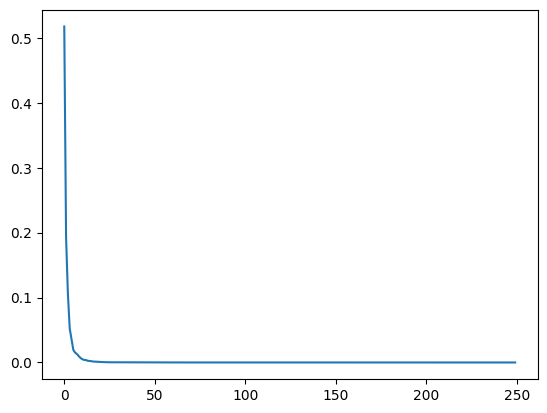

In [27]:
# apply PCA to the original data
pca = PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
print(np.cumsum(pca.explained_variance_ratio_[0:20]))
plt.plot(pca.explained_variance_ratio_)
plt.show()

## Model Refinement

In [28]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
y_prediction_lr = clf_lr.predict(X_val)
print("Logistic Regression Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_lr)))
print("F1 score: " + str(f1_score(y_val, y_prediction_lr, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_lr, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_lr, average='macro')))

Logistic Regression Classifier
Accuracy: 0.884792837239048
F1 score: 0.39475818390157397
Recall score: 0.366464318190779
Precision score: 0.45092742569264554


c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


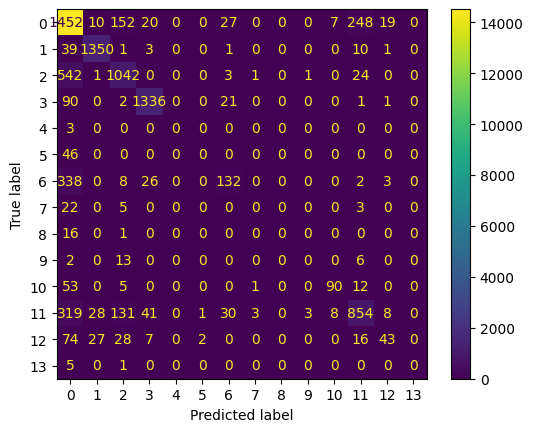

In [29]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, y_prediction_lr)
ConfusionMatrixDisplay(c_matrix).plot()

In [30]:
clf_kn = KNeighborsClassifier(3)
clf_kn.fit(X_train, y_train)
y_prediction_kn = clf_kn.predict(X_val)
print("K Neighbours Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_kn)))
print("F1 score: " + str(f1_score(y_val, y_prediction_kn, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_kn, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_kn, average='macro')))

K Neighbours Classifier
Accuracy: 0.9801288200630396
F1 score: 0.7100244643034197
Recall score: 0.6738495998324711
Precision score: 0.8017609243151551


c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


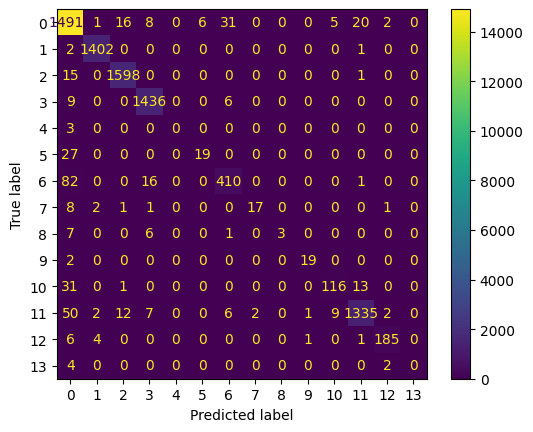

In [31]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, y_prediction_kn)
ConfusionMatrixDisplay(c_matrix).plot()

In [32]:
clf_mlp_100 = MLPClassifier(hidden_layer_sizes=(100))
clf_mlp_100.fit(X_train, y_train)
y_prediction_mlp_100 = clf_mlp_100.predict(X_val)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_100)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_100, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_100, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_100, average='macro')))

MLP Classifier
Accuracy: 0.9830523959618108
F1 score: 0.7711761734690866
Recall score: 0.744673092234271
Precision score: 0.8097815926064224


c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


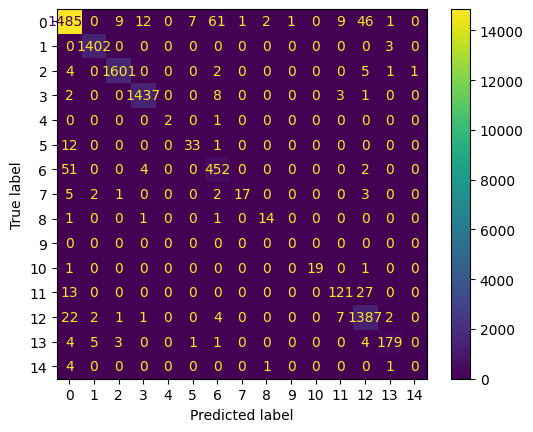

In [33]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, y_prediction_mlp_100)
ConfusionMatrixDisplay(c_matrix).plot()

In [34]:
clf_mlp_50_50_50 = MLPClassifier(hidden_layer_sizes=(50,50,50))
clf_mlp_50_50_50.fit(X_train, y_train)
y_prediction_mlp_50_50_50 = clf_mlp_50_50_50.predict(X_val)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_50_50_50)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_50_50_50, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_50_50_50, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_50_50_50, average='macro')))

MLP Classifier
Accuracy: 0.9838289708099219
F1 score: 0.675027635552065
Recall score: 0.6506293632436594
Precision score: 0.7222670037461926


c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


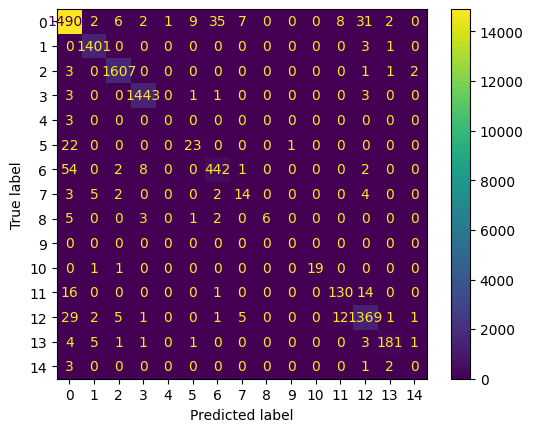

In [35]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, y_prediction_mlp_50_50_50)
ConfusionMatrixDisplay(c_matrix).plot()

In [36]:
clf_mlp_100_100_100_100 = MLPClassifier(hidden_layer_sizes=(100,100,100,100))
clf_mlp_100_100_100_100.fit(X_train, y_train)
y_prediction_100_100_100_100 = clf_mlp_100_100_100_100.predict(X_val)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_100_100_100_100)))
print("F1 score: " + str(f1_score(y_val, y_prediction_100_100_100_100, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_100_100_100_100, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_100_100_100_100, average='macro')))

MLP Classifier
Accuracy: 0.9861130144808369
F1 score: 0.7734121288061224
Recall score: 0.73976410161337
Precision score: 0.8323589492354554


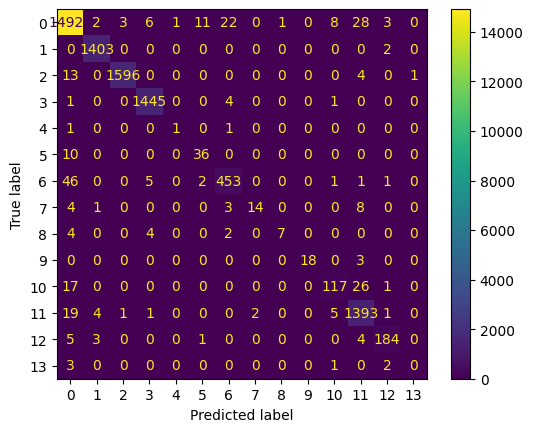

In [37]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, y_prediction_100_100_100_100)
ConfusionMatrixDisplay(c_matrix).plot()

In [38]:
clf_mlp_100_pca = MLPClassifier(hidden_layer_sizes=(100))
clf_mlp_100_pca.fit(X_train_pca, y_train)
y_prediction_mlp_100_pca = clf_mlp_100_pca.predict(X_val_pca)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_100_pca)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_100_pca, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_100_pca, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_100_pca, average='macro')))

MLP Classifier
Accuracy: 0.9821387784934448
F1 score: 0.8087750198853411
Recall score: 0.7839324796452986
Precision score: 0.8410072295992724


In [39]:
clf_mlp_100_der = MLPClassifier(hidden_layer_sizes=(100,100,100,100))
clf_mlp_100_der.fit(X_train_with_der, y_train)
y_prediction_mlp_100_der = clf_mlp_100_der.predict(X_val_with_der)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_100_der)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_100_der, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_100_der, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_100_der, average='macro')))

MLP Classifier
Accuracy: 0.9862957379745101
F1 score: 0.8003884867272898
Recall score: 0.7697336088233574
Precision score: 0.8540610144483799


In [40]:
clf_mlp_5s_der = MLPClassifier(hidden_layer_sizes=(100,30,30,30,30))
clf_mlp_5s_der.fit(X_train_with_der, y_train)
y_prediction_mlp_5s_der = clf_mlp_5s_der.predict(X_val_with_der)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_5s_der)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_5s_der, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_5s_der, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_5s_der, average='macro')))

MLP Classifier
Accuracy: 0.985519163126399
F1 score: 0.7411594084125915
Recall score: 0.6974213414824725
Precision score: 0.8136963050648519


c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
clf_mlp_100_shifted = MLPClassifier(hidden_layer_sizes=(100))
clf_mlp_100_shifted.fit(X_train_Shifted, y_train)
y_prediction_mlp_100_shifted = clf_mlp_100_shifted.predict(X_val_Shifted)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_100_shifted)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_100_shifted, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_100_shifted, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_100_shifted, average='macro')))

MLP Classifier
Accuracy: 0.9836462473162487
F1 score: 0.8086173783086197
Recall score: 0.7907468411720898
Precision score: 0.8358761692504774


c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [43]:
clf_kn_shifted = KNeighborsClassifier(1)
clf_kn_shifted.fit(X_train_Shifted, y_train)
y_prediction_kn_shifted = clf_kn_shifted.predict(X_val_Shifted)
print("K Neighbours Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_kn_shifted)))
print("F1 score: " + str(f1_score(y_val, y_prediction_kn_shifted, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_kn_shifted, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_kn_shifted, average='macro')))

K Neighbours Classifier
Accuracy: 0.9834178429491572
F1 score: 0.7528601835961147
Recall score: 0.7342790753623228
Precision score: 0.7826657057268319


In [44]:
import xgboost as xgb

In [50]:
clf_xgb = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=10)
clf_xgb.fit(X_train_Shifted, y_train, eval_set=[(X_val_Shifted, y_val)])
y_prediction_xgb = clf_xgb.predict(X_val_Shifted)
print("XGB Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_xgb)))
print("F1 score: " + str(f1_score(y_val, y_prediction_xgb, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_xgb, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_xgb, average='macro')))

[0]	validation_0-mlogloss:1.08027
[1]	validation_0-mlogloss:0.78994
[2]	validation_0-mlogloss:0.61208
[3]	validation_0-mlogloss:0.48543
[4]	validation_0-mlogloss:0.39338
[5]	validation_0-mlogloss:0.32680
[6]	validation_0-mlogloss:0.27424
[7]	validation_0-mlogloss:0.23419
[8]	validation_0-mlogloss:0.20359
[9]	validation_0-mlogloss:0.17986
[10]	validation_0-mlogloss:0.16077
[11]	validation_0-mlogloss:0.14566
[12]	validation_0-mlogloss:0.13338
[13]	validation_0-mlogloss:0.12412
[14]	validation_0-mlogloss:0.11615
[15]	validation_0-mlogloss:0.11038
[16]	validation_0-mlogloss:0.10534
[17]	validation_0-mlogloss:0.10091
[18]	validation_0-mlogloss:0.09726
[19]	validation_0-mlogloss:0.09430
[20]	validation_0-mlogloss:0.09181
[21]	validation_0-mlogloss:0.08920
[22]	validation_0-mlogloss:0.08738
[23]	validation_0-mlogloss:0.08571
[24]	validation_0-mlogloss:0.08411
[25]	validation_0-mlogloss:0.08276
[26]	validation_0-mlogloss:0.08167
[27]	validation_0-mlogloss:0.08073
[28]	validation_0-mlogloss:0.0

c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

In [ ]:
clf_cnn = Sequential()
